In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt

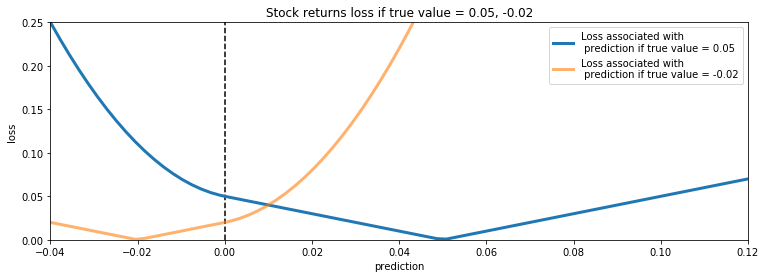

In [2]:
figsize(12.5, 4)


def stock_loss(true_return, yhat, alpha=100.):
    if true_return * yhat < 0:
        # opposite signs, not good
        return alpha * yhat ** 2 - np.sign(true_return) * yhat \
            + abs(true_return)
    else:
        return abs(true_return - yhat)


true_value = .05
pred = np.linspace(-.04, .12, 75)

plt.plot(pred, [stock_loss(true_value, _p) for _p in pred],
         label="Loss associated with\n prediction if true value = 0.05", lw=3)
plt.vlines(0, 0, .25, linestyles="--")

plt.xlabel("prediction")
plt.ylabel("loss")
plt.xlim(-0.04, .12)
plt.ylim(0, 0.25)

true_value = -.02
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], alpha=0.6,
         label="Loss associated with\n prediction if true value = -0.02", lw=3)
plt.legend()
plt.title("Stock returns loss if true value = 0.05, -0.02");

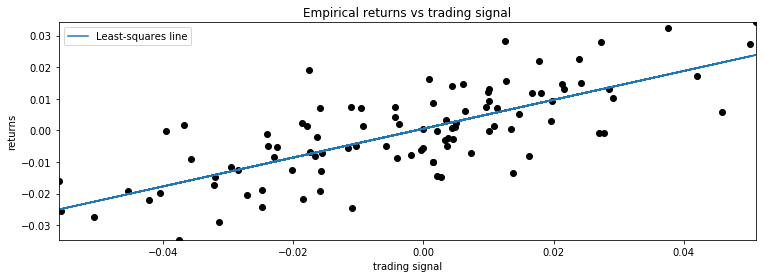

In [3]:
# Code to create artificial data
N = 100
X = 0.025 * np.random.randn(N)
Y = 0.5 * X + 0.01 * np.random.randn(N)

ls_coef_ = np.cov(X, Y)[0, 1] / np.var(X)
ls_intercept = Y.mean() - ls_coef_ * X.mean()

plt.scatter(X, Y, c="k")
plt.xlabel("trading signal")
plt.ylabel("returns")
plt.title("Empirical returns vs trading signal")
plt.plot(X, ls_coef_ * X + ls_intercept, label="Least-squares line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="upper left");

 [-----------------100%-----------------] 100000 of 100000 complete in 12.2 secPlotting alpha
Plotting beta
Plotting prec


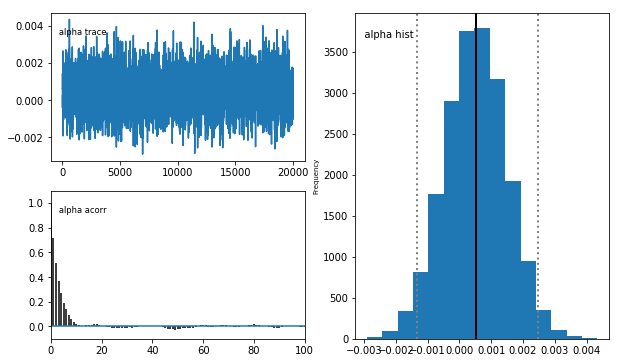

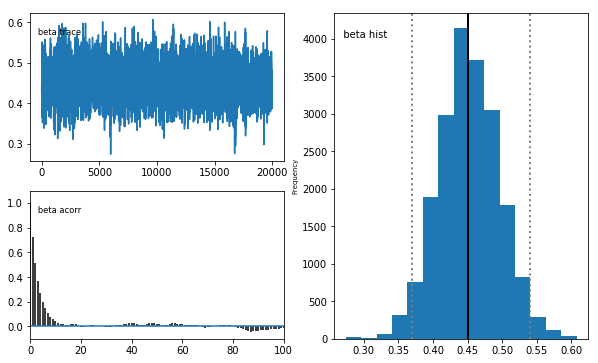

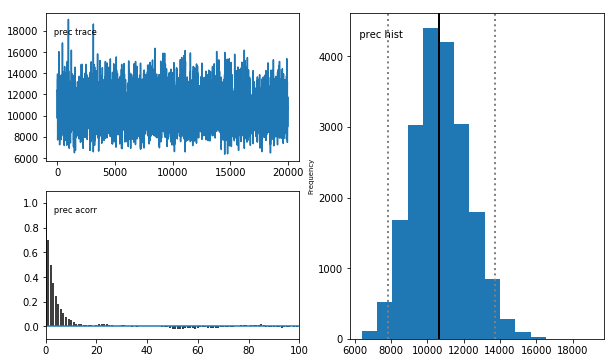

In [4]:
import pymc as pm
from pymc.Matplot import plot as mcplot

std = pm.Uniform("std", 0, 100, trace=False)  # this needs to be explained.


@pm.deterministic
def prec(U=std):
    return 1.0 / (U) ** 2

beta = pm.Normal("beta", 0, 0.0001)
alpha = pm.Normal("alpha", 0, 0.0001)


@pm.deterministic
def mean(X=X, alpha=alpha, beta=beta):
    return alpha + beta * X

obs = pm.Normal("obs", mean, prec, value=Y, observed=True)
mcmc = pm.MCMC([obs, beta, alpha, std, prec])

mcmc.sample(100000, 80000)
mcplot(mcmc)

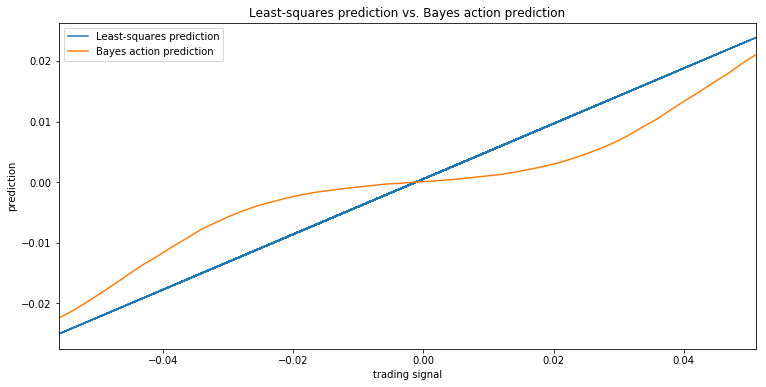

In [5]:
figsize(12.5, 6)
from scipy.optimize import fmin


def stock_loss(price, pred, coef=500):
    """vectorized for numpy"""
    sol = np.zeros_like(price)
    ix = price * pred < 0
    sol[ix] = coef * pred ** 2 - np.sign(price[ix]) * pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

tau_samples = mcmc.trace("prec")[:]
alpha_samples = mcmc.trace("alpha")[:]
beta_samples = mcmc.trace("beta")[:]

N = tau_samples.shape[0]

noise = 1. / np.sqrt(tau_samples) * np.random.randn(N)

possible_outcomes = lambda signal: alpha_samples + beta_samples * signal \
    + noise


opt_predictions = np.zeros(50)
trading_signals = np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals):
    _possible_outcomes = possible_outcomes(_signal)
    tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
    opt_predictions[i] = fmin(tomin, 0, disp=False)


plt.xlabel("trading signal")
plt.ylabel("prediction")
plt.title("Least-squares prediction vs. Bayes action prediction")
plt.plot(X, ls_coef_ * X + ls_intercept, label="Least-squares prediction")
plt.xlim(X.min(), X.max())
plt.plot(trading_signals, opt_predictions, label="Bayes action prediction")
plt.legend(loc="upper left");